In [1]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold
import warnings
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random



warnings.filterwarnings('ignore')

pd.set_option('display.max_column', None)

c:\Users\Benedict\python_folder\AIMS_assignments\aims_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_file_path = "./data/output_revised.csv"

In [3]:
df = pd.read_csv(data_file_path)

In [4]:
# df.head(2)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['datetime'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.set_index('datetime')



In [5]:
district_id_mapper = dict(zip(df['ID'], df['district']))

### visualizing for Quasi constant features:

In [ ]:
def check_quasiconstant(df):
    
    threshold = 0.99  

    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df.select_dtypes(include=['object', 'category']).columns

    # --- Detect Quasi-Constant Numerical Features ---
    num_selector = VarianceThreshold(threshold=0.01)  # Variance threshold
    num_selector.fit(df[numerical_features])
    quasi_constant_num = numerical_features[~num_selector.get_support()]
    print(f"Quasi-constant numerical features: {list(quasi_constant_num)}")

    # --- Detect Quasi-Constant Categorical Features ---
    quasi_constant_cat = [
        col for col in categorical_features 
        if df[col].value_counts(normalize=True).values[0] > threshold
    ]
    print(f"Quasi-constant categorical features: {list(quasi_constant_cat)}")

    quasi_constant_features = list(quasi_constant_num) + list(quasi_constant_cat)
    print(f"Total Quasi-constant features: {quasi_constant_features}")

In [16]:
check_quasiconstant(df[df['ID']== 1])

Quasi-constant numerical features: ['ndvi', 'ID', 'prop_poor', 'prop_Number_of_children_3plus', 'prop_Rural', 'prop_drinking_TreatedWater', 'prop_Time_get_Water60_plus_min', 'prop_No_Toilet', 'prop_Has_Electricity', 'prop_Has_Radio', 'prop_floor_Material_natural', 'prop_Sleeping_Rooms_3plus', 'prop_share_Toilet', 'prop_Has_sleeping_mosquito_net', 'prop_some_or_all_children_slept_under_net_last_night', 'prop_house_holds_share_toilet_9Plus', 'prop_Has_mobilephone', 'prop_dwelling_sprayed_last_12_Months', 'prop_with_3Plus_mosquito_nets', 'prop_children_under_mosquito_bed_nets_previous_night2Plus', 'prop_uneducated', 'number_of_doctors', 'Name_of_healthcare_facility1']
Quasi-constant categorical features: ['district', 'district_SPH', 'ADM1_PT', 'ADM2_PT', 'ADM2_PCODE']
Total Quasi-constant features: ['ndvi', 'ID', 'prop_poor', 'prop_Number_of_children_3plus', 'prop_Rural', 'prop_drinking_TreatedWater', 'prop_Time_get_Water60_plus_min', 'prop_No_Toilet', 'prop_Has_Electricity', 'prop_Has_Ra

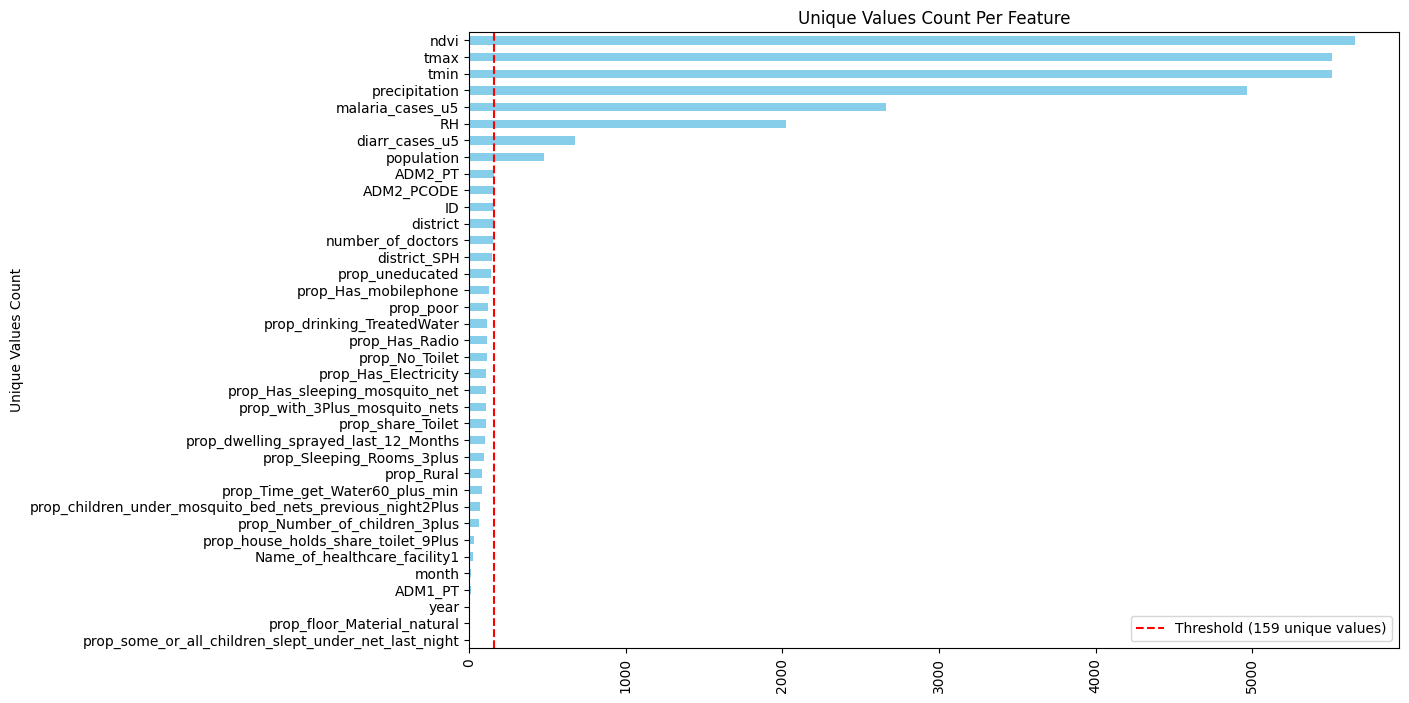

In [39]:
plt.figure(figsize=(12, 8))
df.nunique().sort_values().plot(kind="barh", color="skyblue")
plt.axvline(df['district'].nunique(), color="r", linestyle="--", label=f"Threshold ({df['district'].nunique()} unique values)")
plt.ylabel("Unique Values Count")
plt.title("Unique Values Count Per Feature")
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [7]:
features_of_interest =  df.loc[:, df.nunique() > 159].columns.to_list()

In [8]:
features_of_interest.append("ID")

In [9]:
features_of_interest

['malaria_cases_u5',
 'diarr_cases_u5',
 'population',
 'tmin',
 'tmax',
 'RH',
 'precipitation',
 'ndvi',
 'ID']

In [10]:
# Splitting train and test data:

df_copy = df.copy()
df_copy = df_copy[features_of_interest]


train_data = df_copy[df_copy.index < '2018-03-01']
test_data = df_copy[df_copy.index >= '2018-03-01']

In [17]:
X = train_data.copy()
y = X[['ID','diarr_cases_u5']]
X = X.drop(['malaria_cases_u5', 'diarr_cases_u5'], axis=1)

In [18]:
X.isnull().sum()

population        0
tmin             26
tmax             26
RH                0
precipitation     0
ndvi             49
ID                0
dtype: int64

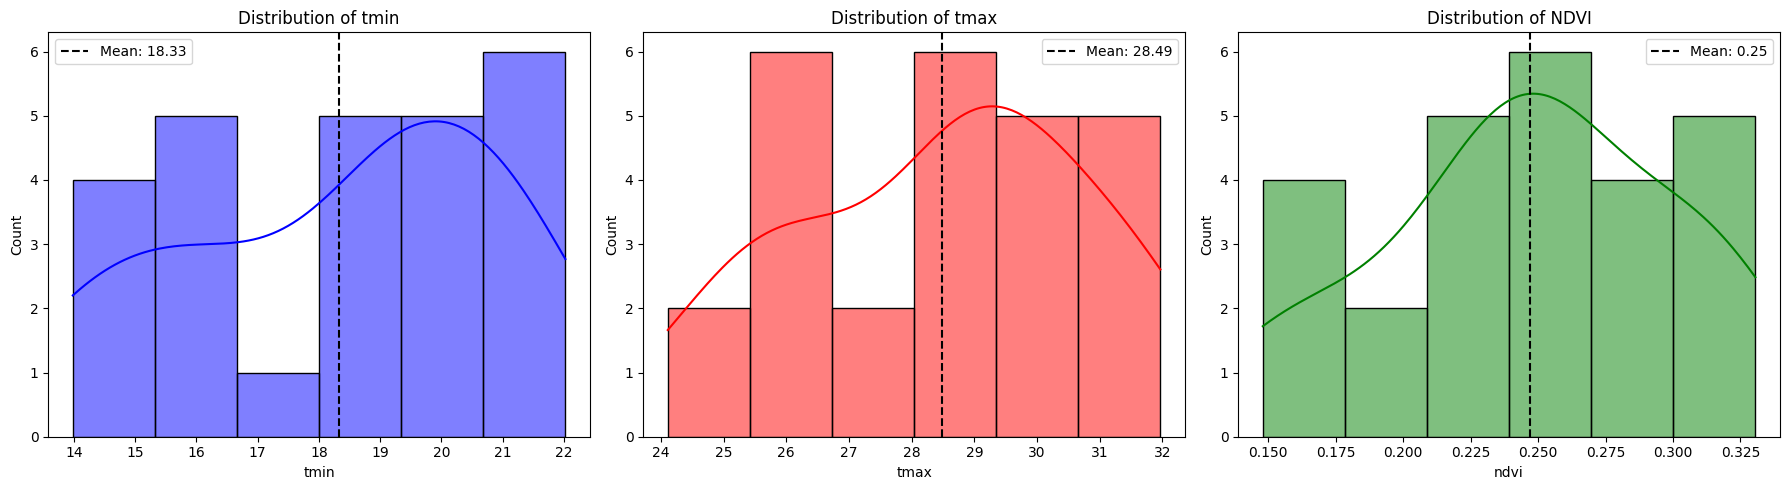

In [59]:
# visualizing distributions and mean positions

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

mean_tmin = X[X['ID'] == 1]['tmin'].mean()
mean_tmax = X[X['ID'] == 1]['tmax'].mean()
mean_ndvi = X[X['ID'] == 1]['ndvi'].mean()

# Plot distributions and add vertical lines for the means
sns.histplot(X[X['ID'] == 1]['tmin'], ax=axes[0], kde=True, color='blue')
axes[0].axvline(mean_tmin, color='black', linestyle='--', label=f'Mean: {mean_tmin:.2f}')
axes[0].set_title("Distribution of tmin")
axes[0].legend()

sns.histplot(X[X['ID'] == 1]['tmax'], ax=axes[1], kde=True, color='red')
axes[1].axvline(mean_tmax, color='black', linestyle='--', label=f'Mean: {mean_tmax:.2f}')
axes[1].set_title("Distribution of tmax")
axes[1].legend()

sns.histplot(X[X['ID'] == 1]['ndvi'], ax=axes[2], kde=True, color='green')
axes[2].axvline(mean_ndvi, color='black', linestyle='--', label=f'Mean: {mean_ndvi:.2f}')
axes[2].set_title("Distribution of NDVI")
axes[2].legend()

plt.tight_layout()
plt.show()


In [21]:
# filling missing values with mean from Train set ( used for both Train and Test set to avoid data leakage):

X_filled = X.fillna(X.mean())

test_data_filled = test_data.fillna(X.mean())


#### Training Sarimax models on a district level:


In [22]:
X_filled

,population,tmin,tmax,RH,precipitation,ndvi,ID
datetime,,,,,,,
2016-01-01,398318.033138,21.294078,30.052979,84.781250,316.312258,0.249722,1
2016-02-01,398318.033138,21.270510,29.678297,87.459821,129.972256,0.323964,1
2016-03-01,398318.033138,22.023369,29.522761,89.664286,354.284895,0.312545,1
2016-04-01,398318.033138,19.596098,26.568178,90.843750,85.360640,0.289376,1
2016-05-01,398318.033138,16.402166,25.480120,85.982143,0.818778,0.298299,1
...,...,...,...,...,...,...,...
2017-10-01,100360.271249,19.708305,33.555722,31.133929,4.732262,0.121469,159
2017-11-01,100360.271249,19.746846,30.562689,42.973214,64.420831,0.158989,159
2017-12-01,100360.271249,19.749573,28.374167,78.559028,196.140925,0.260180,159


In [23]:
def subset_train_sarimax(district_id, X=X_filled, y=y):

    subset_x = X[X['ID'] == district_id].iloc[:, :-1]
    subset_y = y[y['ID'] == district_id]['diarr_cases_u5']

    
    sarimax_model = auto_arima(subset_y, X=subset_x,
                           suppress_warnings=True, stepwise=True)
    
    test_x = test_data[test_data['ID'] == district_id][['population','tmin','tmax','RH','precipitation','ndvi']]

    predictions = pd.Series(sarimax_model.predict(n_periods=10, X = test_x))

    output_df = pd.DataFrame({
    'ID': [district_id] * len(predictions), 
    'predicted_cases': predictions
})

    return output_df

10

In [24]:
# ========== Training and Prediting ==============

date_range = pd.date_range(start="2018-03-01", end="2018-12-01", freq='MS')
final_output = pd.DataFrame(columns=['ID','predicted_cases'])
error_ids = []

for id_ in tqdm(df['ID'].unique(), total=df['ID'].nunique()):
    try:
        res_ = subset_train_sarimax(id_)
        final_output = pd.concat([final_output, res_])
        
    except Exception as e:

        print(f"Error {e} occurred on id : {id_}")

        manual_ = pd.DataFrame({
            'ID': [id_] * len(date_range), 
            'predicted_cases': [0] * len(date_range)
        }, index=date_range)

        final_output = pd.concat([final_output, manual_])
        error_ids.append(id_)

        continue
    

 31%|███▏      | 50/159 [00:40<02:01,  1.12s/it]

Error Found non-finite values in dataframe occurred on id : 51


 33%|███▎      | 53/159 [00:42<01:26,  1.23it/s]

Error Found non-finite values in dataframe occurred on id : 54
Error Found non-finite values in dataframe occurred on id : 55


100%|██████████| 159/159 [02:14<00:00,  1.18it/s]


In [25]:
final_output[final_output.index > '2018-06-01']

,ID,predicted_cases
2018-07-01,1,170.432556
2018-08-01,1,150.823272
2018-09-01,1,119.103216
2018-10-01,1,114.316170
2018-11-01,1,120.970684
...,...,...
2018-08-01,159,310.787780
2018-09-01,159,300.365455
2018-10-01,159,264.977338
2018-11-01,159,282.839579


In [97]:
final_output[final_output['ID'] == 135]

,ID,predicted_cases
2018-03-01,135,0.0
2018-04-01,135,0.0
2018-05-01,135,0.0
2018-06-01,135,0.0
2018-07-01,135,0.0
2018-08-01,135,0.0
2018-09-01,135,0.0
2018-10-01,135,0.0
2018-11-01,135,0.0
2018-12-01,135,0.0


In [26]:
abs_final = abs(final_output)

In [27]:
# test_data[(test_data.index > '2018-06-01') & (test_data.ID != 51) & (test_data.ID != 54) & (test_data.ID != 55)]
test_data[(test_data.index > '2018-06-01')]

,malaria_cases_u5,diarr_cases_u5,population,tmin,tmax,RH,precipitation,ndvi,ID
datetime,,,,,,,,,
2018-07-01,4942.0,153.0,426166.530298,13.535976,23.761282,79.267857,1.080000,0.265917,1
2018-08-01,3925.0,155.0,426166.530298,14.203088,27.382647,64.901786,0.000000,0.296008,1
2018-09-01,5077.0,169.0,426166.530298,16.712100,29.567314,59.767857,4.578257,0.112081,1
2018-10-01,4855.0,180.0,426166.530298,17.379649,29.780189,62.071429,20.628068,0.126453,1
2018-11-01,5296.0,174.0,426166.530298,17.887158,31.071700,61.589286,30.703161,0.175861,1
...,...,...,...,...,...,...,...,...,...
2018-08-01,378.0,197.0,105748.226360,14.103502,28.164006,42.705357,0.000000,0.129435,159
2018-09-01,363.0,345.0,105748.226360,16.264944,30.659929,37.153571,0.000000,0.099243,159
2018-10-01,253.0,362.0,105748.226360,17.310614,30.725253,38.441964,2.550407,0.153720,159


In [28]:
def get_results(test_data, pred_df, timeframe = '2018-06-01'):

    test = test_data[(test_data.index > '2018-06-01')]['diarr_cases_u5']
    pred = pred_df[pred_df.index > timeframe]['predicted_cases']

    if len(test) != len(pred):
        raise ValueError("The lengths of the test and prediction data do not match!")

    mae = mean_absolute_error(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(test, pred)

    mape = np.mean(np.abs((test - pred) / test)) * 100

    # Optionally: Calculate Symmetric MAPE (SMAPE)
    smape = 2 * np.mean(np.abs(test - pred) / (np.abs(test) + np.abs(pred))) * 100

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    # print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    # print(f"Symmetric MAPE (SMAPE): {smape:.2f}%")

In [29]:
get_results(test_data, final_output)

Mean Absolute Error (MAE): 60.50
Mean Squared Error (MSE): 13171.27
Root Mean Squared Error (RMSE): 114.77
R-squared (R²): 0.81


In [30]:
get_results(test_data, abs_final)

Mean Absolute Error (MAE): 58.98
Mean Squared Error (MSE): 12891.77
Root Mean Squared Error (RMSE): 113.54
R-squared (R²): 0.82


### visualizing outputs

In [31]:
vertical_line_date = pd.to_datetime('2018-02-01')
vertical_line_date_2 = pd.to_datetime('2018-07-01')


In [32]:
def plot_pred(district_id, ax, final_output=final_output):
    
    subset_df = df[df['ID'] == district_id]['diarr_cases_u5']
    predictions = final_output[final_output['ID'] == district_id]['predicted_cases']

    new_series = subset_df.copy()
    new_series.update(predictions)

    # Plot on the provided axis
    ax.plot(subset_df, color='red', label='Observed')
    ax.axvline(vertical_line_date, color='green', linestyle='--')
    ax.axvline(vertical_line_date_2, color='green', linestyle='--')
    ax.plot(new_series, color='blue', label='Predicted')

    ax.set_title(f'District {district_id}')
    ax.legend()
    ax.tick_params(axis='x', rotation=45);



def plot_singlepred(district_id, final_output=final_output):
    subset_df = df[df['ID'] == district_id]['diarr_cases_u5']
    predictions = final_output[final_output['ID'] == district_id]['predicted_cases']

    new_series = subset_df.copy()
    new_series.update(predictions) 

    plt.figure(figsize=(12,8))


    plt.plot(subset_df, color='red', label='Observed')
    plt.plot(new_series,  color='blue', label='Predicted')
    plt.title(f'District {district_id}')
    plt.legend()
    plt.axvline(vertical_line_date, color='green', linestyle='--')
    plt.axvline(vertical_line_date_2, color='green', linestyle='--');



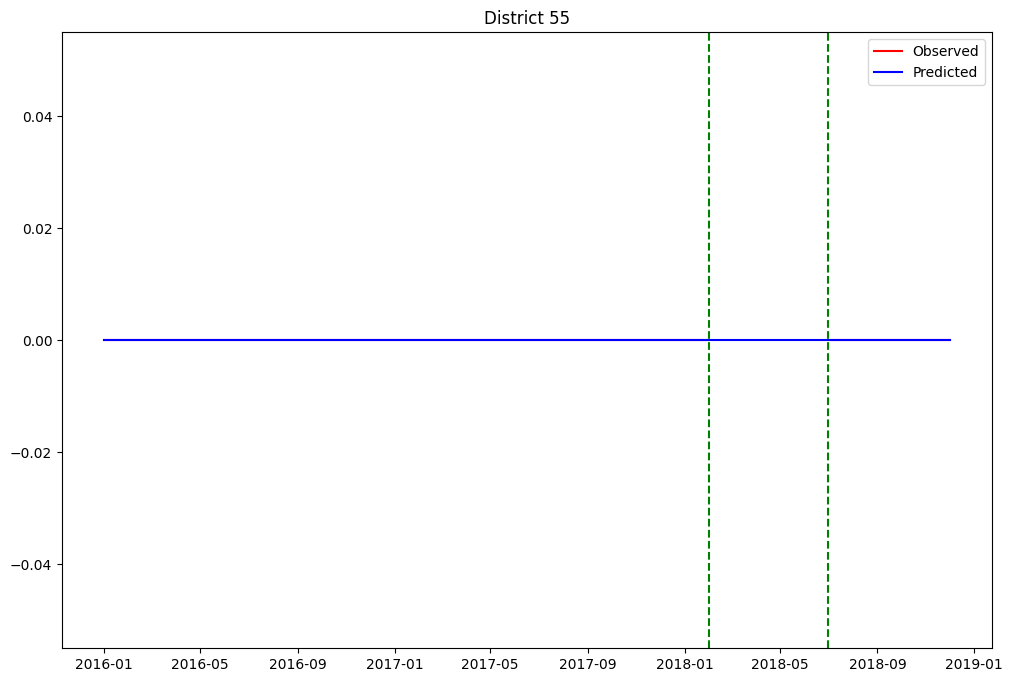

In [36]:
all_district_ids = list(df['ID'].unique())  # Replace with actual district IDs
selected_districts = random.sample(all_district_ids, 6)

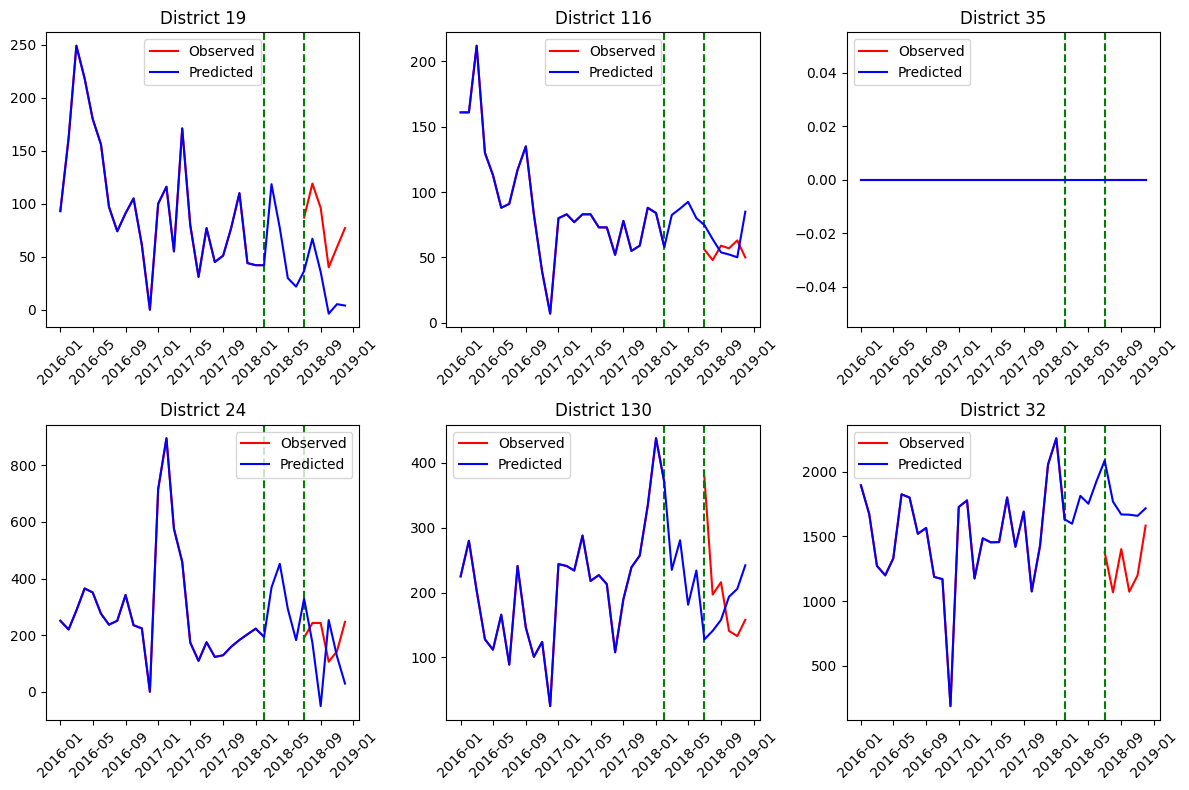

In [37]:
# Create a 3x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Loop through each subplot and call plot_pred
for i, ax in enumerate(axes):
    district_id = selected_districts[i]
    plot_pred(district_id, ax)

# Adjust layout and show the plot
plt.tight_layout()

### Carrying out interpolation

In [38]:
check_df  = df.copy()

check_df['interpolated'] = check_df.groupby('district')['diarr_cases_u5'].apply(
    lambda group: group.interpolate(method='polynomial', order=3)
).reset_index(level=0, drop=True)

In [39]:
check_df

,district,year,month,district_SPH,malaria_cases_u5,diarr_cases_u5,population,tmin,tmax,RH,precipitation,ndvi,ADM1_PT,ADM2_PT,ADM2_PCODE,ID,prop_poor,prop_Number_of_children_3plus,prop_Rural,prop_drinking_TreatedWater,prop_Time_get_Water60_plus_min,prop_No_Toilet,prop_Has_Electricity,prop_Has_Radio,prop_floor_Material_natural,prop_Sleeping_Rooms_3plus,prop_share_Toilet,prop_Has_sleeping_mosquito_net,prop_some_or_all_children_slept_under_net_last_night,prop_house_holds_share_toilet_9Plus,prop_Has_mobilephone,prop_dwelling_sprayed_last_12_Months,prop_with_3Plus_mosquito_nets,prop_children_under_mosquito_bed_nets_previous_night2Plus,prop_uneducated,number_of_doctors,Name_of_healthcare_facility1,interpolated
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,alto molocue,2016,1,alto molocue,5361.0,361.0,398318.033138,21.294078,30.052979,84.781250,316.312258,0.249722,Zambezia,Alto Molocue,MZ1101,1,30.82,0.00,77.98,17.64,0.00,21.76,31.65,37.42,0,1.76,14.29,85.55,0,0.00,69.29,1.76,1.76,0.00,13.33,2433.0,17.0,361.0
2016-02-01,alto molocue,2016,2,alto molocue,4417.0,213.0,398318.033138,21.270510,29.678297,87.459821,129.972256,0.323964,Zambezia,Alto Molocue,MZ1101,1,30.82,0.00,77.98,17.64,0.00,21.76,31.65,37.42,0,1.76,14.29,85.55,0,0.00,69.29,1.76,1.76,0.00,13.33,2433.0,17.0,213.0
2016-03-01,alto molocue,2016,3,alto molocue,5778.0,193.0,398318.033138,22.023369,29.522761,89.664286,354.284895,0.312545,Zambezia,Alto Molocue,MZ1101,1,30.82,0.00,77.98,17.64,0.00,21.76,31.65,37.42,0,1.76,14.29,85.55,0,0.00,69.29,1.76,1.76,0.00,13.33,2433.0,17.0,193.0
2016-04-01,alto molocue,2016,4,alto molocue,3573.0,92.0,398318.033138,19.596098,26.568178,90.843750,85.360640,0.289376,Zambezia,Alto Molocue,MZ1101,1,30.82,0.00,77.98,17.64,0.00,21.76,31.65,37.42,0,1.76,14.29,85.55,0,0.00,69.29,1.76,1.76,0.00,13.33,2433.0,17.0,92.0
2016-05-01,alto molocue,2016,5,alto molocue,3306.0,124.0,398318.033138,16.402166,25.480120,85.982143,0.818778,0.298299,Zambezia,Alto Molocue,MZ1101,1,30.82,0.00,77.98,17.64,0.00,21.76,31.65,37.42,0,1.76,14.29,85.55,0,0.00,69.29,1.76,1.76,0.00,13.33,2433.0,17.0,124.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,zumbu,2018,8,zumbu,378.0,197.0,105748.226360,14.103502,28.164006,42.705357,0.000000,0.129435,Tete,Zumbu,MZ1015,159,64.07,0.86,78.46,19.30,5.85,63.84,5.79,40.39,0,4.08,12.30,88.40,0,0.11,51.48,5.84,3.64,1.91,33.37,1411.0,10.0,197.0
2018-09-01,zumbu,2018,9,zumbu,363.0,345.0,105748.226360,16.264944,30.659929,37.153571,0.000000,0.099243,Tete,Zumbu,MZ1015,159,64.07,0.86,78.46,19.30,5.85,63.84,5.79,40.39,0,4.08,12.30,88.40,0,0.11,51.48,5.84,3.64,1.91,33.37,1411.0,10.0,345.0
2018-10-01,zumbu,2018,10,zumbu,253.0,362.0,105748.226360,17.310614,30.725253,38.441964,2.550407,0.153720,Tete,Zumbu,MZ1015,159,64.07,0.86,78.46,19.30,5.85,63.84,5.79,40.39,0,4.08,12.30,88.40,0,0.11,51.48,5.84,3.64,1.91,33.37,1411.0,10.0,362.0


In [ ]:
check_df[check_df['district']]

In [40]:
def plot_interpolated_series(ax, id_):
    # plt.figure(figsize=(12,8))
    district_data = check_df[check_df['ID'] == id_]

    ax.plot(district_data['interpolated'], label='Interpolated Data', color='blue')
    ax.plot(district_data['diarr_cases_u5'], label='Original Data', color='red')
    ax.set_title(f"district: {id_}")
    ax.legend()
    ax.axvline(vertical_line_date, color='green', linestyle='--')
    ax.axvline(vertical_line_date_2, color='green', linestyle='--')
    ax.tick_params(axis='x', rotation=45) ;


In [41]:
def plot_all_districts_interpol(districts, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    axes = axes.flatten()  
    
    for i, district in enumerate(districts):
        if i < len(axes):  
            plot_interpolated_series(axes[i], district)
        else:
            axes[i].axis('off')  

    plt.tight_layout()
    plt.show()


In [ ]:
# districts = random.sample(list(train_data['district'].unique()), 6)


### Comparing Plots :

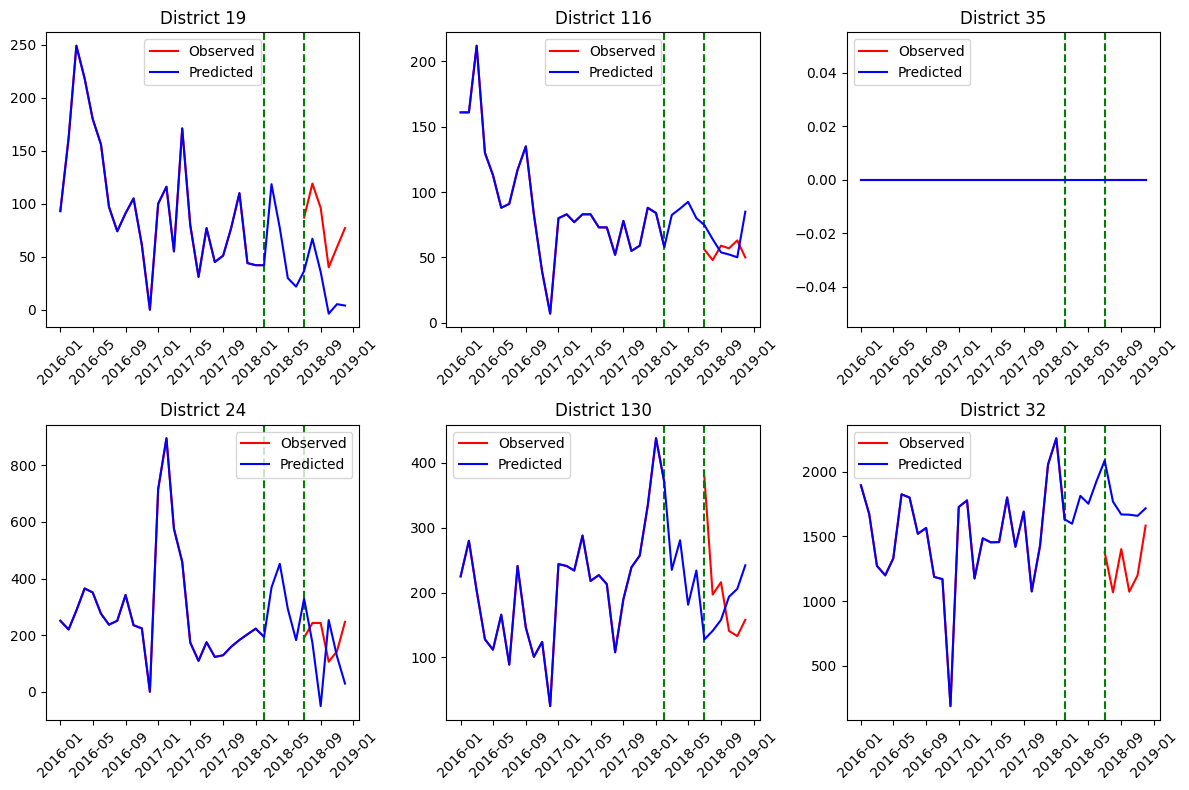

In [42]:
# Create a 3x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Loop through each subplot and call plot_pred
for i, ax in enumerate(axes):
    district_id = selected_districts[i]
    plot_pred(district_id, ax)

# Adjust layout and show the plot
plt.tight_layout()

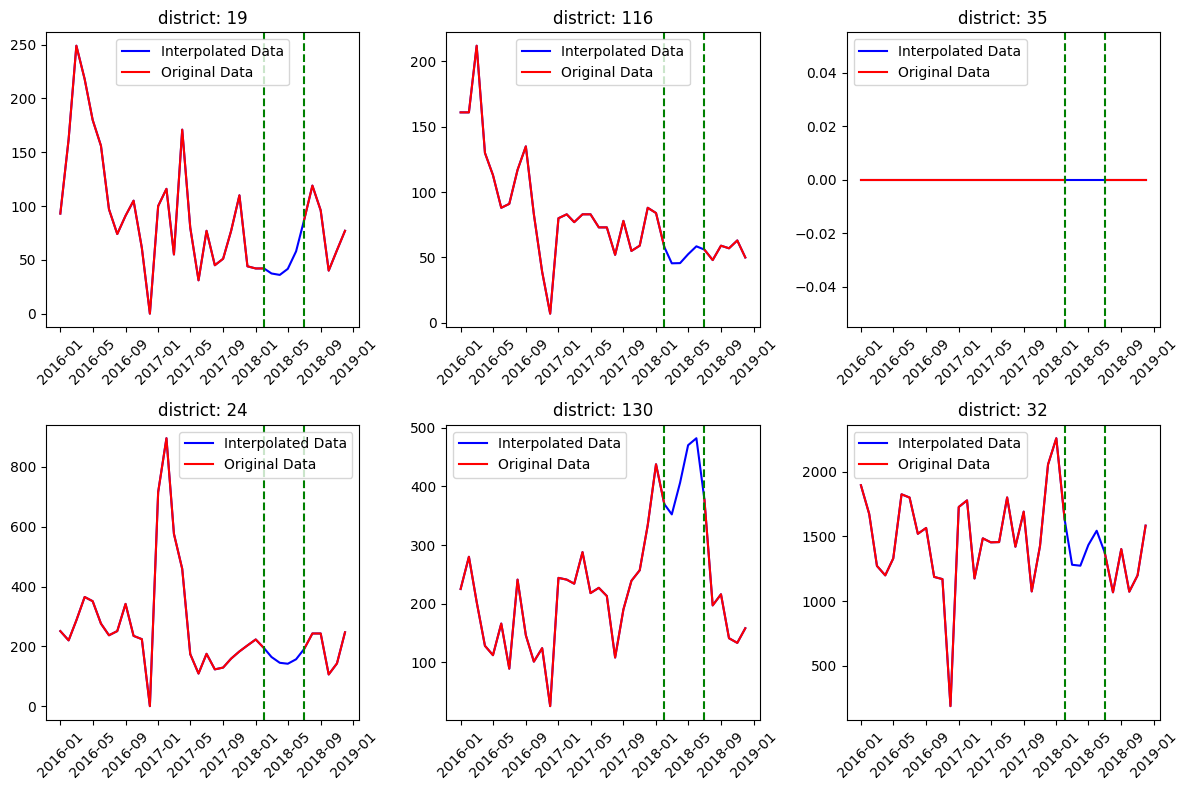

In [43]:
plot_all_districts_interpol(selected_districts, nrows=2, ncols=3)

### Plotting interpolation and Sarimax

In [44]:
def plot_sarimax_interpol(district_id, ax, final_output=final_output, interpol = check_df):
    
    subset_df = df[df['ID'] == district_id]['diarr_cases_u5']
    predictions = final_output[final_output['ID'] == district_id]['predicted_cases']

    new_series = subset_df.copy()
    new_series.update(predictions)
    interpol_ = interpol[interpol['ID'] == district_id]
    # Plot on the provided axis
    ax.plot(subset_df, color='red', label='Observed')
    ax.axvline(vertical_line_date, color='green', linestyle='--')
    ax.axvline(vertical_line_date_2, color='green', linestyle='--')
    ax.plot(new_series, color='blue', label='Predicted')
    ax.plot(interpol_['interpolated'], label='Interpolated Data', color="#B8860B")

    ax.set_title(f'District {district_id}')
    ax.legend()
    ax.tick_params(axis='x', rotation=45);

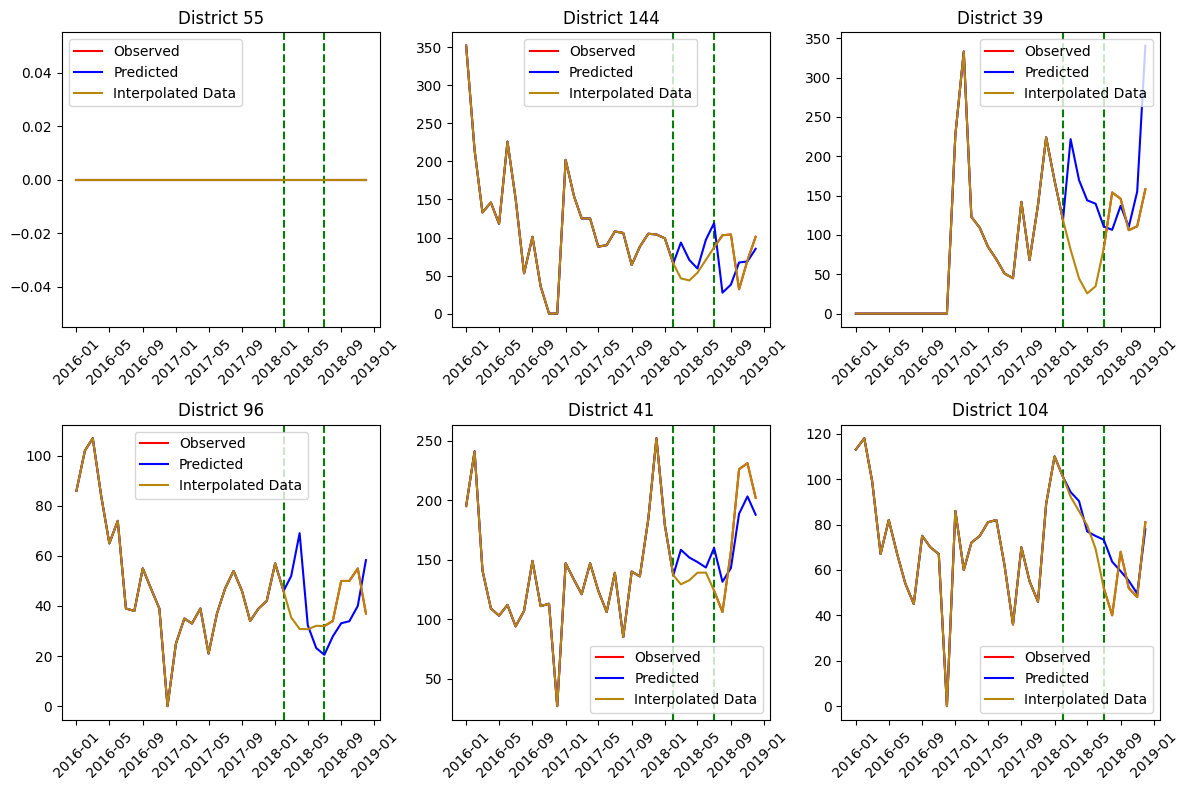

In [45]:
all_district_ids = list(df['ID'].unique())  # Replace with actual district IDs
selected_districts = random.sample(all_district_ids, 6)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Loop through each subplot and call plot_pred
for i, ax in enumerate(axes):
    district_id = selected_districts[i]
    plot_sarimax_interpol(district_id, ax)

# Adjust layout and show the plot
plt.tight_layout()

In [46]:
for k,v in district_id_mapper.items():
    if v == 154:
        print(k)

In [47]:
def plot_singlepred_interpol(district_id, final_output=final_output, interpol = check_df):
    subset_df = df[df['ID'] == district_id]['diarr_cases_u5']
    predictions = final_output[final_output['ID'] == district_id]['predicted_cases']

    new_series = subset_df.copy()
    new_series.update(predictions) 
    interpol_ = interpol[interpol['ID'] == district_id]

    plt.figure(figsize=(12,8))


    plt.plot(subset_df, color='red', label='Observed')
    plt.plot(new_series,  color='blue', label='Predicted')
    plt.plot(interpol_['interpolated'], label='Interpolated Data', color="#B8860B")
    plt.title(f'District {district_id}')
    plt.legend()
    plt.axvline(vertical_line_date, color='green', linestyle='--')
    plt.axvline(vertical_line_date_2, color='green', linestyle='--');



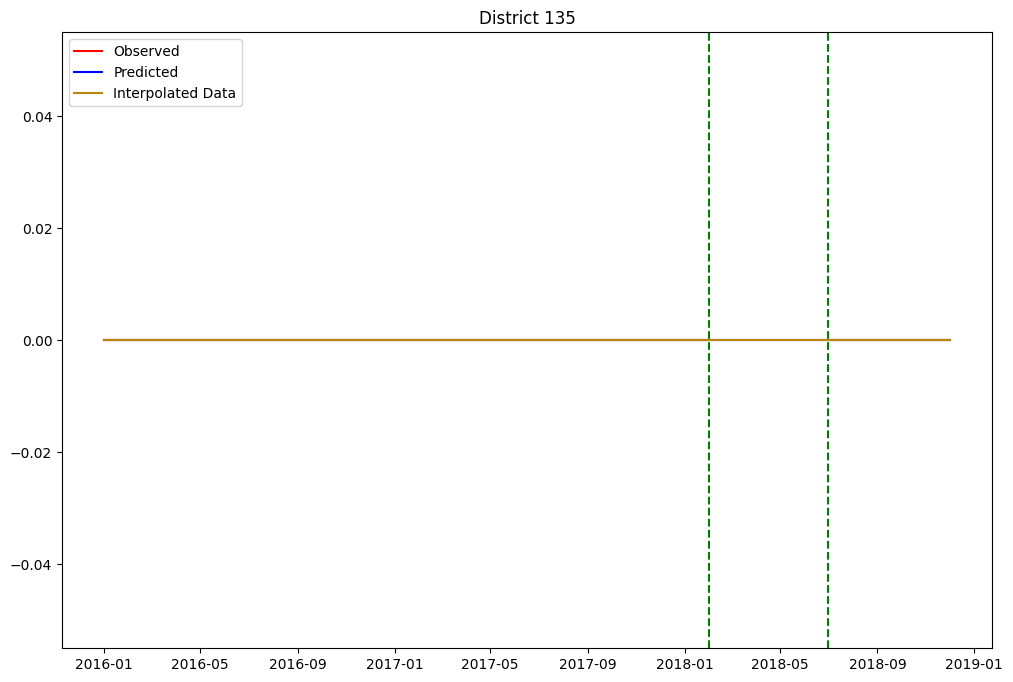

In [48]:
plot_singlepred_interpol(135)

### Ensembling The Models

In [186]:
xgboost_pred = pd.read_csv('./data/this_is_final_predictions.csv')
xgboost_pred.drop('Unnamed: 0', axis=1, inplace=True)

In [188]:
xgboost_pred['ID'] = xgboost_pred['district'].map(district_id_mapper)

In [189]:
xgboost_pred

,district,year,month,predictions,ID
0,alto molocue,2018,3,5210.66600,1
1,alto molocue,2018,4,4326.74300,1
2,alto molocue,2018,5,3440.65450,1
3,alto molocue,2018,6,3931.39900,1
4,alto molocue,2018,7,3744.96560,1
...,...,...,...,...,...
1585,zumbu,2018,8,477.00037,159
1586,zumbu,2018,9,540.81210,159
1587,zumbu,2018,10,513.59010,159
1588,zumbu,2018,11,418.29974,159


In [190]:
xgboost_pred['datetime'] = pd.to_datetime(xgboost_pred[['year', 'month']].assign(day=1))
xgboost_pred = xgboost_pred.set_index('datetime')

In [191]:
xgboost_pred

,district,year,month,predictions,ID
datetime,,,,,
2018-03-01,alto molocue,2018,3,5210.66600,1
2018-04-01,alto molocue,2018,4,4326.74300,1
2018-05-01,alto molocue,2018,5,3440.65450,1
2018-06-01,alto molocue,2018,6,3931.39900,1
2018-07-01,alto molocue,2018,7,3744.96560,1
...,...,...,...,...,...
2018-08-01,zumbu,2018,8,477.00037,159
2018-09-01,zumbu,2018,9,540.81210,159
2018-10-01,zumbu,2018,10,513.59010,159


In [49]:
def plot_singlepred_interpol_xgb(district_id, ax, final_output=final_output, interpol = check_df):

    subset_df = df[df['ID'] == district_id]['diarr_cases_u5']
    predictions = final_output[final_output['ID'] == district_id]['predicted_cases']

    new_series = subset_df.copy()
    new_series.update(predictions) 
    interpol_ = interpol[interpol['ID'] == district_id]
    # xgb = xgboost[xgboost['ID'] == district_id]


    ax.plot(subset_df, color='red', label='Observed')
    ax.plot(new_series,  color='blue', label='Predicted')
    ax.plot(interpol_['interpolated'], label='Interpolated Data', color="#B8860B")
    # ax.plot(xgb['predictions'], label='XGBoost', color="k")
    ax.set_title(f'District {district_id}')
    ax.legend()
    ax.axvline(vertical_line_date, color='green', linestyle='--')
    ax.axvline(vertical_line_date_2, color='green', linestyle='--')
    ax.tick_params(axis='x', rotation=45);



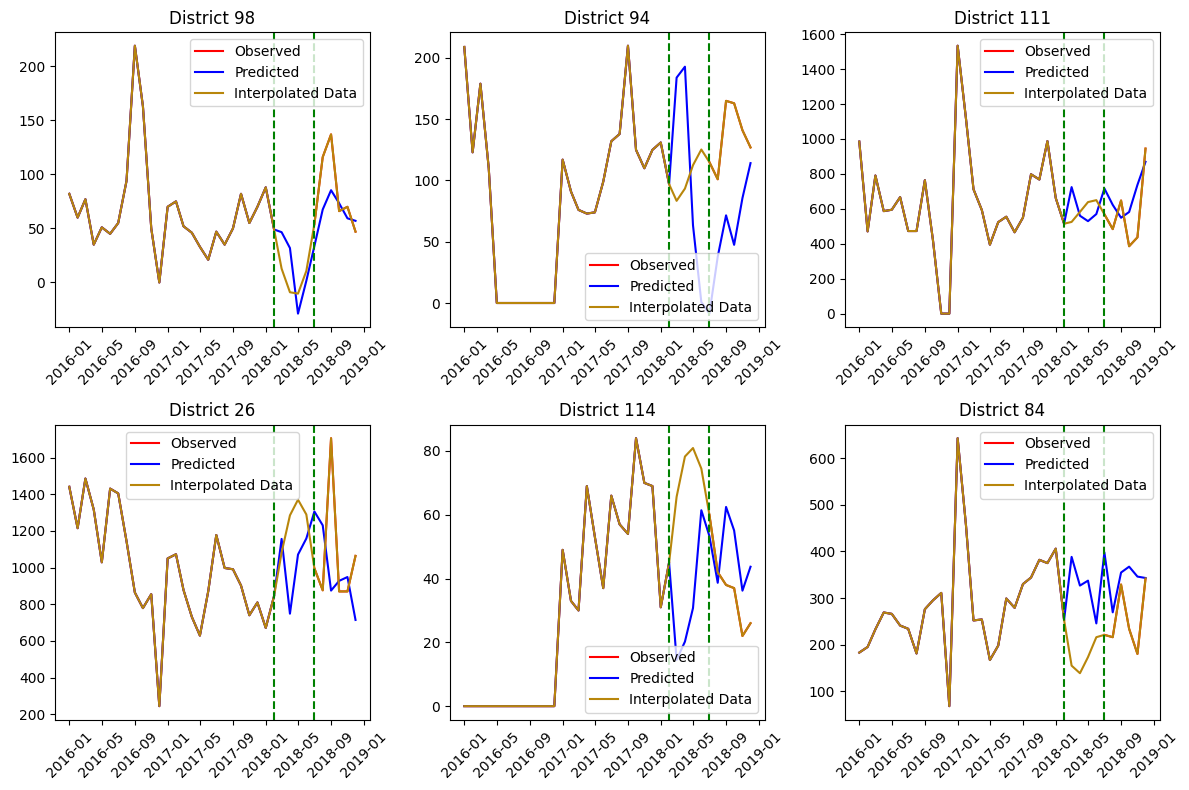

In [50]:
all_district_ids = list(df['ID'].unique())  # Replace with actual district IDs
selected_districts = random.sample(all_district_ids, 6)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Loop through each subplot and call plot_pred
for i, ax in enumerate(axes):
    district_id = selected_districts[i]
    plot_singlepred_interpol_xgb(district_id, ax)

# Adjust layout and show the plot
plt.tight_layout()

### Carrying out an ensemble:

In [52]:
# model_1 = final_output[(final_output.index > '2018-02-01') & (final_output.index <= '2018-06-01')][['ID','predicted_cases']] # sarimax
# model_2 = check_df[(check_df.index > '2018-02-01') & (check_df.index <= '2018-06-01')]['interpolated'] # interpolation
# model_3 = xgboost_pred[(xgboost_pred.index > '2018-02-01') & (xgboost_pred.index <= '2018-06-01')]['predictions'] # xgboost


model_1 = final_output[(final_output.index > '2018-02-01')][['ID','predicted_cases']] # sarimax
model_2 = check_df[(check_df.index > '2018-02-01')]['interpolated'] # interpolation
# model_3 = xgboost_pred[(xgboost_pred.index > '2018-02-01')]['predictions'] # xgboost


In [74]:
ensemble = pd.DataFrame(columns=['ID','ensembles'])
ensemble['ID'] = model_1['ID'].values
# ensemble['ensembles'] = 0.2 * model_1['predicted_cases'].values + 0.6 * model_2.values + 0.2 * model_3.values
ensemble['ensembles'] = 1.0 * model_2.values + 0 * model_1['predicted_cases'].values

In [75]:
ensemble.set_index(model_1.index, inplace=True)

In [55]:
def plot_singlepred_interpol_xgb_ens(district_id, ax, final_output=final_output, interpol = check_df, ensemble=ensemble):

    subset_df = df[df['ID'] == district_id]['diarr_cases_u5']
    predictions = final_output[final_output['ID'] == district_id]['predicted_cases']

    new_series = subset_df.copy()
    new_series.update(predictions) 
    interpol_ = interpol[interpol['ID'] == district_id]
    # xgb = xgboost[xgboost['ID'] == district_id]
    ense = ensemble[ensemble['ID'] == district_id]


    ax.plot(subset_df, color='red', label='Observed')
    ax.plot(new_series,  color='blue', label='Predicted')
    ax.plot(interpol_['interpolated'], label='Interpolated Data', color="#B8860B")
    # ax.plot(xgb['predictions'], label='XGBoost', color="k")
    ax.plot(ense['ensembles'], label='Ensembles', color="cyan")
    ax.set_title(f'District {district_id}')
    ax.legend()
    ax.axvline(vertical_line_date, color='green', linestyle='--')
    ax.axvline(vertical_line_date_2, color='green', linestyle='--')
    ax.tick_params(axis='x', rotation=45);



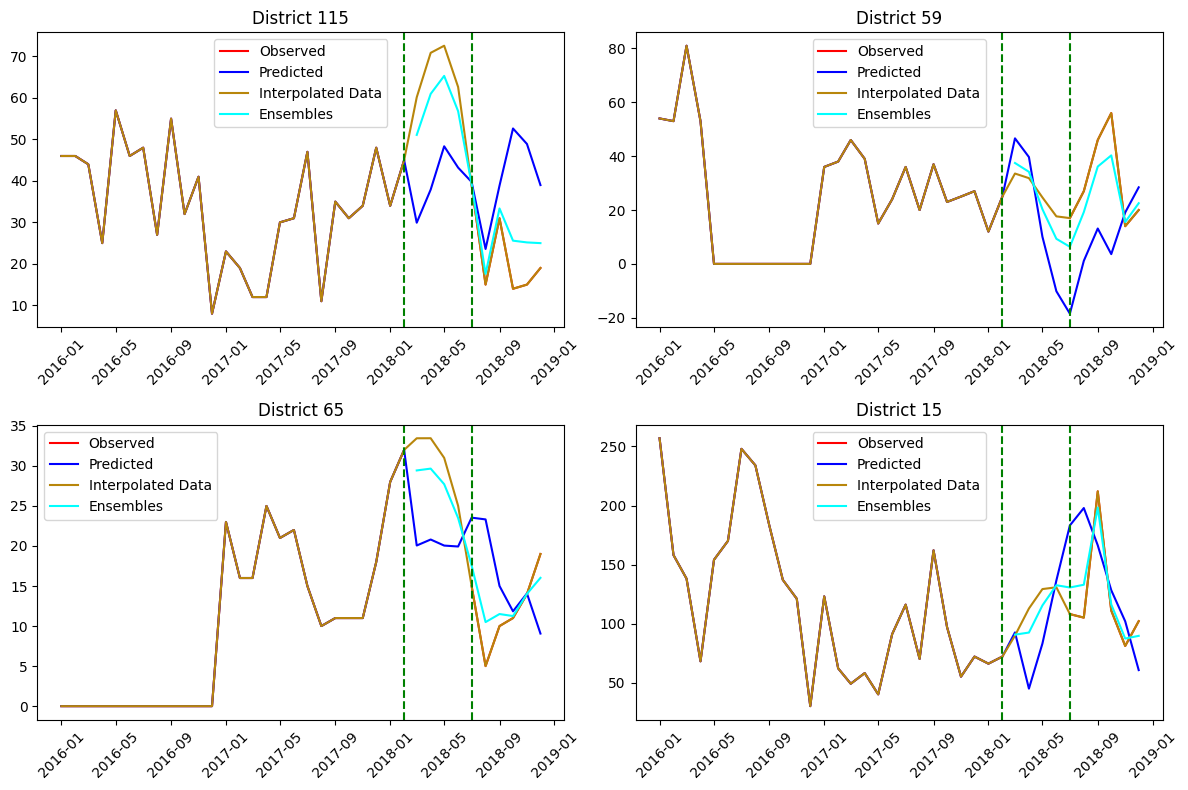

In [56]:
all_district_ids = list(df['ID'].unique())  # Replace with actual district IDs
selected_districts = random.sample(all_district_ids, 4)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each subplot and call plot_pred
for i, ax in enumerate(axes):
    district_id = selected_districts[i]
    plot_singlepred_interpol_xgb_ens(district_id, ax)

# Adjust layout and show the plot
plt.tight_layout()

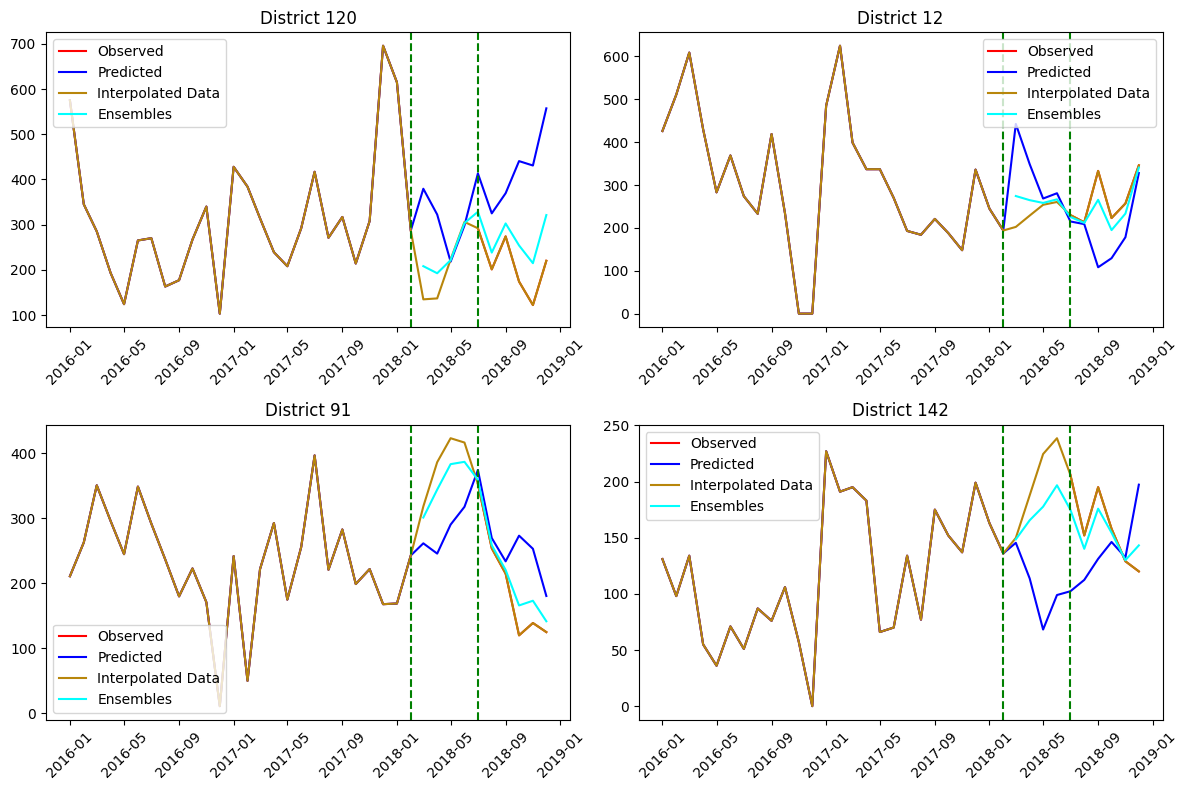

In [57]:


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each subplot and call plot_pred
for i, ax in enumerate(axes):
    district_id = [120, 12, 91, 142][i]
    plot_singlepred_interpol_xgb_ens(district_id, ax)

# Adjust layout and show the plot
plt.tight_layout()

In [76]:
filtered_ensemble = ensemble[(ensemble.index > '2018-02-01') & (ensemble.index <= '2018-06-01')]

In [77]:
submission = pd.DataFrame(columns=['Group_name', 'Year', 'Month', 'District_ID', 'Diarrheal_prediction'])

In [78]:
ensemble['ensembles'].values

array([189.23334146, 192.1717772 , 180.61960164, ..., 362.        ,
       236.        , 387.        ])

In [79]:
submission['Diarrheal_prediction'] = filtered_ensemble['ensembles'].values

In [80]:
submission

,Group_name,Year,Month,District_ID,Diarrheal_prediction
0,NaN,NaN,NaN,NaN,189.233341
1,NaN,NaN,NaN,NaN,192.171777
2,NaN,NaN,NaN,NaN,180.619602
3,NaN,NaN,NaN,NaN,163.963394
4,NaN,NaN,NaN,NaN,174.801671
...,...,...,...,...,...
631,NaN,NaN,NaN,NaN,59.005598
632,NaN,NaN,NaN,NaN,346.620571
633,NaN,NaN,NaN,NaN,394.574704
634,NaN,NaN,NaN,NaN,419.080118


In [81]:
a = filtered_ensemble.reset_index()

In [82]:
submission['Year'] = a['index'].dt.year
submission['Month'] = a['index'].dt.month
submission['District_ID'] = filtered_ensemble['ID'].values
submission['Group_name'] = 'Group_2'

In [83]:
submission['ID'] = submission['District_ID'].map(district_id_mapper)

In [84]:
submission['District_ID'] = submission['ID'].values

In [85]:
submission.drop('ID', axis=1, inplace=True)

In [86]:
submission

,Group_name,Year,Month,District_ID,Diarrheal_prediction
0,Group_2,2018,3,alto molocue,189.233341
1,Group_2,2018,4,alto molocue,192.171777
2,Group_2,2018,5,alto molocue,180.619602
3,Group_2,2018,6,alto molocue,163.963394
4,Group_2,2018,3,ancuabe,174.801671
...,...,...,...,...,...
631,Group_2,2018,6,zavala,59.005598
632,Group_2,2018,3,zumbu,346.620571
633,Group_2,2018,4,zumbu,394.574704
634,Group_2,2018,5,zumbu,419.080118


In [87]:
submission.to_csv('./data/Group_2_Project_AIPH_diarrheal_.csv', index=False)